### Installing Qiskit

#### Normal installation

In [51]:
%pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#### GPU installation

In [52]:
# %pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer-gpu python-dotenv

### Libraries Importing


In [53]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from dotenv import load_dotenv
from sympy import *
import json
import time
import os
import itertools



load_dotenv()
init_printing()
simulation_time = time.time()  # to calculate simulation time

In [54]:
backend = AerSimulator(method="statevector")
print(backend.available_devices())

('CPU',)


#### Use GPU

In [55]:
# backend.set_options(device="GPU")

#### Use real quantum

In [56]:
# services = []

# for i in range(1, 6):
#     services.append(QiskitRuntimeService(
#         channel="ibm_quantum", token=os.getenv(f"TOKEN{i}")))

# # backend = service.backend("ibm_osaka") # for real quantum
# # backend = service.backend("ibm_kyoto") # for real quantum


### Problem Definition

In [57]:
conf = json.load(open("../conf_24.json", "r"))

In [58]:
N = conf["N"]  # Number of Teachers
M = conf["M"]  # Number of Classes
H = conf["H"]  # Number of hours in week

# required_qubits = (M * N * H) + (M * H) + (N * H)
required_qubits = (N * H * M)
iterations = 0

random_seed = conf["random_seed"]
shots = conf["shots"] * 10
layers = 5

print("Requried Qubits: ", required_qubits)

Requried Qubits:  12


In [59]:
# T_i is binary string denoting the available hours for each i Teacher
# C_j is binary string denoting the available hours for each j Class

T = conf["T"]
C = conf["C"]

R = conf["R"]  # R_ij must be either 0 or 1

terms_count = 0
equations = []

### Formulation

#### Equations

In [60]:
for i in range(1, N + 1):
  for j in range(1, M + 1):
    temp = total = 0
    for h in range(1, H + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp - R[i-1][j-1])**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

In [61]:
# for j in range(1, M + 1):
#   for h in range(1, H + 1):
#     temp = total = 0
#     for i in range(1, N + 1):
#       temp += symbols(f"f_{i}{j}{h}")
#     total += (temp + symbols(f"τ_{j}{h}") - 1)**2
#     terms_count += len(total.expand().args)
#     equations.append(total.expand())
# equations

In [62]:
temp = []
for j in range(1, M + 1):
  for h in range(1, H + 1):
    for i in range(1, N + 1):
      temp.append(symbols(f"f_{i}{j}{h}"))
temp = list(itertools.combinations(temp,2))
equation = 0

for i in range(len(temp)):
  equation+= temp[i][0] * temp[i][1]
equations.append(equation)
equations

In [63]:
# for i in range(1, N + 1):
#   for h in range(1, H + 1):
#     temp = total = 0
#     for j in range(1, M + 1):
#       temp += symbols(f"f_{i}{j}{h}")
#     total += (temp + symbols(f"λ_{i}{h}") - 1)**2
#     terms_count += len(total.expand().args)
#     equations.append(total.expand())
# equations

In [64]:
# temp = []
# for j in range(1, M + 1):
#   for h in range(1, H + 1):
#     for i in range(1, N + 1):
#       temp.append(symbols(f"f_{i}{j}{h}"))
# temp = list(itertools.combinations(temp,2))
# equation = 0
# for i in range(len(temp)):
#   equation+= temp[i][0] * temp[i][1]
# equations.append(equation)
# equations

#### Decodeing Equations

In [65]:
def args(equation):
  return Add.make_args(equation)

def prepare_equation(term):
  theta = 1
  terms = []
  if type(term) == Mul:
    for i in term.args:
      if i.is_Integer:
        theta = i
      else:
        terms.append(i)
  else:
    terms.append(term.args[0]) 

  return [theta, decode(terms)]

def decode(terms):
  output = []

  for term in terms:

    term = str(term)

    # if term.startswith("τ"):
    #   j = int(term[2])
    #   h = int(term[3])
    #   output.append((h-1) * M + (j - 1))


    # elif term.startswith("λ"):
    #   i = int(term[2])
    #   h = int(term[3])
    #   output.append((H * M) + ((h-1) * N + (i - 1)))

    if term.startswith("f"):
      i = int(term[2])
      j = int(term[3])
      h = int(term[4])
      # output.append((H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1))
      output.append(((i - 1) * H * M) + ((j - 1) * H) + (h - 1))

  return output


In [66]:
prepared_equations = []
for equation in equations:
    temp = []
    for term in args(equation):
        if len(term.args) != 0:
            print(term,prepare_equation(term))
            
            temp.append(prepare_equation(term))
    prepared_equations.append(temp)

prepared_equations

f_111**2 [1, [0]]
f_112**2 [1, [1]]
f_113**2 [1, [2]]
-2*f_111 [-2, [0]]
-2*f_112 [-2, [1]]
-2*f_113 [-2, [2]]
2*f_111*f_112 [2, [0, 1]]
2*f_111*f_113 [2, [0, 2]]
2*f_112*f_113 [2, [1, 2]]
f_121**2 [1, [3]]
f_122**2 [1, [4]]
f_123**2 [1, [5]]
2*f_121*f_122 [2, [3, 4]]
2*f_121*f_123 [2, [3, 5]]
2*f_122*f_123 [2, [4, 5]]
f_211**2 [1, [6]]
f_212**2 [1, [7]]
f_213**2 [1, [8]]
2*f_211*f_212 [2, [6, 7]]
2*f_211*f_213 [2, [6, 8]]
2*f_212*f_213 [2, [7, 8]]
f_221**2 [1, [9]]
f_222**2 [1, [10]]
f_223**2 [1, [11]]
-2*f_221 [-2, [9]]
-2*f_222 [-2, [10]]
-2*f_223 [-2, [11]]
2*f_221*f_222 [2, [9, 10]]
2*f_221*f_223 [2, [9, 11]]
2*f_222*f_223 [2, [10, 11]]
f_111*f_112 [1, [0, 1]]
f_111*f_113 [1, [0, 2]]
f_111*f_121 [1, [0, 3]]
f_111*f_122 [1, [0, 4]]
f_111*f_123 [1, [0, 5]]
f_111*f_211 [1, [0, 6]]
f_111*f_212 [1, [0, 7]]
f_111*f_213 [1, [0, 8]]
f_111*f_221 [1, [0, 9]]
f_111*f_222 [1, [0, 10]]
f_111*f_223 [1, [0, 11]]
f_112*f_113 [1, [1, 2]]
f_112*f_121 [1, [1, 3]]
f_112*f_122 [1, [1, 4]]
f_112*f_123 

### Implementation

#### Objective Function

In [67]:
def f(i, j, h):
    return int(T[i-1][h-1] == C[j-1][h-1] == '1')


def tau_value(bit_string, j, h):
    return int(bit_string[(h-1) * M + (j - 1)])


def lambda_value(bit_string, i, h):
    return int(bit_string[(H * M) + ((h-1) * N + (i - 1))])


def f_value(bit_string, i, j, h):
    # return int(bit_string[(H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1)])
    return int(bit_string[((i - 1) * H * M) + ((j - 1) * H) + (h - 1)])

In [68]:
def objective(bit_string):
  # since qiskit represent solution in least significant bit format
  bit_string = bit_string[::-1]
  cost = 0
  a = b = c = d = 0
  # equation a
  for i in range(1, N + 1):
      for j in range(1, M + 1):
          for h in range(1, H + 1):
              if f(i, j, h) != f_value(bit_string, i, j, h):
                  cost += 1
                  a += 1

  # equation b
  for i in range(1, N + 1):
      for j in range(1, M + 1):
          temp = 0
          for h in range(1, H + 1):
              temp += f_value(bit_string, i, j, h)
          cost += (temp - R[i-1][j-1])**2
          b += (temp - R[i-1][j-1])**2

#   # equation c
#   for j in range(1, M + 1):
#       for h in range(1, H + 1):
#           temp = 0
#           for i in range(1, N + 1):
#               temp += f_value(bit_string, i, j, h)
#           cost += (temp + tau_value(bit_string, j, h) - 1)**2
#           c += (temp + tau_value(bit_string, j, h) - 1)**2

#   # equation d
#   for i in range(1, N + 1):
#       for h in range(1, H + 1):
#           temp = 0
#           for j in range(1, M + 1):
#               temp += f_value(bit_string, i, j, h)
#           cost += (temp + lambda_value(bit_string, i, h) - 1)**2
#           d += (temp + lambda_value(bit_string, i, h) - 1)**2

  return [cost, a, b, c, d]

#### Circuit

#### Draw circuit 

In [69]:
# qc = QuantumCircuit(required_qubits)

# for i in range(required_qubits):
#     qc.h(i)

# for equation in prepared_equations:
#     for term in equation:
#         theta = int(term[0])
#         locations = term[1]
#         if len(locations) == 1:  # Rz Gate
#             qc.rz(theta * -1 , locations[0])
        
#         elif len(locations) == 2:  # Rzz gate
#             # if locations[0] == locations[1]:
#             #     continue
#             qc.rz(theta * -0.5 , locations[0])
#             qc.rz(theta * -0.5 , locations[1])
#             qc.rzz(theta * 0.5 , locations[0], locations[1])

# for qubit in range(required_qubits - 1):
#     qc.rx(1, qubit)

# qc.draw("mpl")

In [70]:
def layers_gen(p, initial_value=1.0):
    return [initial_value] * p * 2


def create_qaoa_circ(thetas):
    n_layers = len(thetas)//2

    alpha = thetas[n_layers:]
    gamma = thetas[:n_layers]

    qc = QuantumCircuit(required_qubits)

    for i in range(required_qubits):
        if i%2==0:
            qc.x(i)
        qc.h(i)
    
    for layer_index in range(n_layers):
        for equation in prepared_equations:
            for term in equation:
                theta = int(term[0])
                locations = term[1]

                if len(locations) == 1:  # Rz Gate
                    qc.rz(theta * -1 * alpha[layer_index], locations[0])

                elif len(locations) == 2:  # Rzz gate
                    if locations[0] == locations[1]:
                        continue
                    qc.rz(theta * -0.5 * alpha[layer_index], locations[0])
                    qc.rz(theta * -0.5 * alpha[layer_index], locations[1])
                    qc.rzz(theta * 0.5 * alpha[layer_index], locations[0], locations[1])

        for qubit in range(required_qubits - 1):
            qc.rx(2 * gamma[layer_index], qubit)

    qc.measure_all()

    return qc

In [71]:
total = [0] * 4


def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj, a, b, c, d = objective(bit_string)
        total[0] += a
        total[1] += b
        total[2] += c
        total[3] += d
        avg += obj * count
        sum_count += count
    return avg/sum_count


def get_expectation():

    def execute_circ(theta):
        global iterations
        qc = create_qaoa_circ(theta)
        tc = transpile(qc, backend, optimization_level=3,
                       seed_transpiler=random_seed)

        counts = backend.run(tc, seed_simulator=random_seed,
                             shots=shots).result().get_counts()
        print(compute_expectation(counts))
        iterations += 1
        return compute_expectation(counts)

    return execute_circ

In [72]:
from scipy.optimize import minimize,linear_sum_assignment
expectation = get_expectation()
start_time = time.time()
# res = minimize(expectation, layers_gen(layers), method='COBYLA')
res = minimize(expectation, layers_gen(layers), method='COBYQA')
# res = linear_sum_assignment()
res = minimize(expectation, layers_gen(layers), method='L-BFGS-B')
minimization_time = time.time() - start_time

res

13.319140625
13.10390625
13.263671875
13.402734375
13.297265625
13.9056640625
13.410546875
13.5001953125
13.5365234375
13.381640625
13.353125
13.2990234375
13.2787109375
13.3923828125
13.43671875
13.1326171875
13.1326171875
13.3611328125
13.4775390625
13.2142578125
13.5263671875
13.20859375
13.4609375
13.2294921875
13.6533203125
13.09375
13.2359375
12.9478515625
13.0064453125
13.113671875
13.15625
13.021484375
12.8740234375
13.3125
13.130859375
13.369140625
13.35234375
13.0599609375
12.9470703125
13.2875
13.3310546875
13.0654296875
12.93203125
12.8947265625
13.0802734375
12.8408203125
12.8251953125
12.8369140625
12.8083984375
12.904296875
12.86171875
12.876953125
12.8578125
12.833203125
12.7875
12.876171875
12.8404296875
12.7904296875
12.8134765625
12.830859375
12.8234375
12.7890625
12.8439453125
12.8330078125
12.808203125
12.8458984375
12.7982421875
12.807421875
12.857421875
12.8341796875
12.8259765625
12.783984375
12.8126953125
12.7955078125
12.783984375
12.783203125
12.79609375
12.8

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 13.319140625
        x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
             1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
     nfev: 11
     njev: 1
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [73]:
print("a:", total[0])
print("b:", total[1])
print("c:", total[2])
print("d:", total[3])

a: 5429420
b: 7017420
c: 0
d: 0


### Results

2476
-----------------
BINGO
100000000001
1
-----------------
Solution 001101010101 cost: 12 count 121
Solution 101010101101 cost: 12 count 93
Solution 110101010010 cost: 12 count 68
Solution 110101010101 cost: 12 count 65
Solution 001101101101 cost: 16 count 63
Solution 001101010110 cost: 14 count 61
Solution 101101010101 cost: 12 count 55
Solution 101010010101 cost: 8 count 54
Solution 001101010011 cost: 12 count 53
Solution 010010101010 cost: 12 count 44


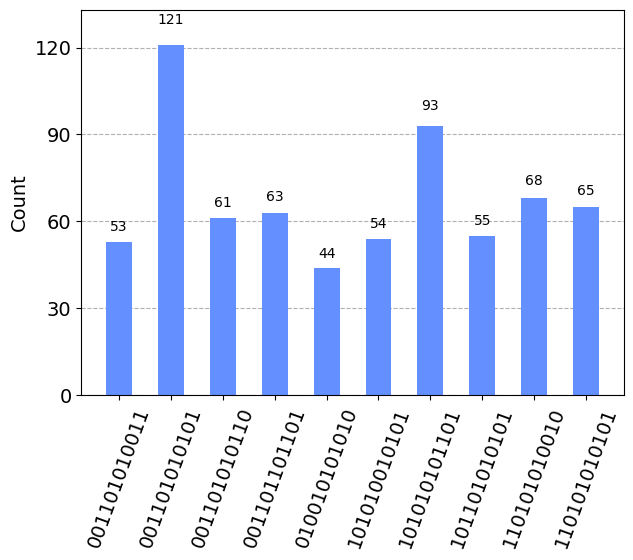

In [74]:
from qiskit.visualization import plot_histogram

qc_res = create_qaoa_circ(res.x)
counts = backend.run(qc_res, seed_simulator=random_seed,
                     shots=shots).result().get_counts()


counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
counts_cost = dict(
    sorted(counts.items(), key=lambda item: item[1], reverse=True))

values = list(counts.values())
binary = list(counts.keys())

output = {}

print(len(counts))

for key in binary:
    if objective(key)[0] == 0:
        print("-----------------")
        print("BINGO")
        print(key)
        print(counts[key])
        print("-----------------")

for key in binary[:10]:
    print("Solution", key, "cost:", objective(key)[0], "count", counts[key])
    output[key] = counts[key]

# plot_histogram(output).savefig(f"./png/{H}_{M}_{N}_{shots}_{layers}_{time.time_ns()}.png")
plot_histogram(output)

In [75]:
sol = required_qubits
sol_bin = ""

for i in counts:
  ob = objective(i)[0]
  if ob < sol:
    sol = ob
    sol_bin = i

counts["H"] = H
counts["M"] = M
counts["N"] = N
counts["shots"] = shots
counts["layers"] = layers
counts["solution"] = sol_bin
counts["solution_cost"] = sol
counts["solution_count"] = counts[sol_bin]
counts["minimization_time"] = minimization_time
counts["execution_time"] = time.time() - simulation_time
counts["iterations"] = iterations 

print("Solution",sol_bin ,"cost:",sol,"count", counts[sol_bin])

Solution 100000000001 cost: 0 count 1


In [76]:
file = open(f"../json/simulation/6/{H}_{M}_{N}_{shots}_{layers}_simulation.json", "w")
file.write(json.dumps(counts))
file.flush()

In [77]:
counts["execution_time"]

In [78]:
minimization_time